In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics.cluster import adjusted_mutual_info_score, mutual_info_score, normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

import umap

from time import perf_counter

from utilities import drawSketch, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap, get_pca_components_for_var, plot_pca_components, df_to_heatmap, get_reconstruction_error, get_max_along_df_axis, cluster_acc


# Define settings

In [5]:
# Import shared settings
from settings import random_state, n_jobs, test_size, pRows, pCols, pColNames, pScale, nSamples, names, accuracyMin, accuracyMax, max_iter
# Override settings
n_jobs = 4

In [6]:
# Used for plot names
dim_red_name = "clustering"
casename = f"quickdraw_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Load and curate data

In [7]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 2500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 2500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [8]:
# Create X, y, X_test, y_test using just the features we care about...

X_full = data.loc[:, pColNames].values
print(f'X_full.shape = {X_full.shape}')
y_full = data.loc[:, 'classNumber'].values
print(f'y_full.shape = {y_full.shape}')

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')


print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print(f'Ratio of y_test=1 to y_test=0 for Test data: {(y_test == 1).sum() / float(len(y_test))} (should be 0.5)')

X_full.shape = (5000, 784)
y_full.shape = (5000,)

X.shape = (4000, 784)
y.shape = (4000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

X_test.shape = (1000, 784)
y_test.shape = (1000,)
Ratio of y_test=1 to y_test=0 for Test data: 0.5 (should be 0.5)


# Apply Clustering 

In [42]:
class gmm_wrapper(GaussianMixture):
    def transform(self,X):
        return self.predict_proba(X)

In [37]:
n_components = 34
drs = {
    'No DR': None,
    'pca': PCA(n_components=n_components, random_state=random_state),
    'ica': FastICA(n_components=n_components, random_state=random_state, max_iter=max_iter),
    'rp': SparseRandomProjection(n_components=n_components, random_state=random_state),
    'umap': umap.UMAP(n_components=n_components, random_state=random_state),
}

In [74]:
hidden_layer_sizes = [(2, ), (4, ), (6, )]

results = []

clusterers = ['km', 'gmm']

n_clusterss = [2, 9, 15, 25, 34, 50, 98, 156, 206]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_test = scaler.transform(X_test)

In [75]:
for dr_name, dr in drs.items():
    if dr is None:
        X_reduced = X.copy()
        X_reduced_test = X_test.copy()
    else:
        X_reduced = dr.fit_transform(X_scaled)
        X_reduced_test = dr.transform(X_scaled_test)

    for name in clusterers:
        for n_clusters in n_clusterss:
            print(f"{dr_name} {name} n_clust={n_clusters}", end='')

            results.append({})
            results[-1]['dr'] = dr_name
            results[-1]['clusterer'] = name
            results[-1]['n_clusters'] = n_clusters
#             results[-1]['dr_obj'] = dr
            
            # Prepare clusterer and predict labels
            if name == 'km':
                clusterer = KMeans(n_clusters, random_state=random_state)
            elif name == 'gmm':
                clusterer = gmm_wrapper(n_clusters, random_state=random_state)
            else:
                raise Exception(".")
            clusterer.fit(X_reduced)
            
            X_clustered = clusterer.transform(X_reduced)
            X_test_clustered = clusterer.transform(X_reduced_test)
            y_pred = clusterer.predict(X_reduced)
            y_test_pred = clusterer.predict(X_reduced_test)

            # Store clustering results
            results[-1]['y_pred'] = y_pred
            results[-1]['y_test_pred'] = y_test_pred
#             results[-1]['cluster_obj'] = clusterer
                        
            # Compute internal metrics
            results[-1]['accuracy'] = cluster_acc(y, y_pred)
            results[-1]['accuracy_test'] = cluster_acc(y_test, y_test_pred)
            results[-1]['score'] = clusterer.score(X_reduced)
            results[-1]['score_test'] = clusterer.score(X_reduced_test)
            results[-1]['silhouette'] = silhouette_score(X_reduced, results[-1]['y_pred'])
            results[-1]['silhouette_test'] = silhouette_score(X_reduced_test, results[-1]['y_test_pred'])
            results[-1]['mutual_info'] = mutual_info_score(y, results[-1]['y_pred'])
            results[-1]['mutual_info_test'] = mutual_info_score(y_test, results[-1]['y_test_pred'])
            results[-1]['normalized_mutual_info'] = normalized_mutual_info_score(y, results[-1]['y_pred'], average_method='arithmetic')
            results[-1]['normalized_mutual_info_test'] = normalized_mutual_info_score(y_test, results[-1]['y_test_pred'], average_method='arithmetic')
            results[-1]['adjusted_rand'] = adjusted_rand_score(y, results[-1]['y_pred'])
            results[-1]['adjusted_rand_test'] = adjusted_rand_score(y_test, results[-1]['y_test_pred'])
            
            print(f" (test) acc={results[-1]['accuracy_test']:.2f}, sil={results[-1]['silhouette_test']:.3f}, nmi={results[-1]['normalized_mutual_info_test']:.3f}", end='')

            # Compute MLP
            param_grid = {'hidden_layer_sizes': hidden_layer_sizes}
            gs = GridSearchCV(MLPClassifier(max_iter=max_iter, random_state=random_state),
                             param_grid=param_grid, verbose=0, cv=3, return_train_score=True,
                             n_jobs=n_jobs)
            gs.fit(X_clustered, y)
            results[-1]['gs_object'] = gs
            results[-1]['mlp_cv_score'] = gs.best_score_
            results[-1]['mlp_test_score'] = gs.score(X_test_clustered, y_test)
                  
            print(f", mlp_cv={results[-1]['mlp_cv_score']}")
        # Save results along the way
        joblib.dump(results, f"{casename}_gs_results_intermediate.pkl")
                  

No DR km n_clust=2 (test) acc=0.58, sil=0.050, nmi=0.018, mlp_cv=0.5
No DR km n_clust=9 (test) acc=0.58, sil=0.033, nmi=0.015, mlp_cv=0.7735
No DR km n_clust=15 (test) acc=0.60, sil=0.024, nmi=0.021, mlp_cv=0.777
No DR km n_clust=25 (test) acc=0.63, sil=0.017, nmi=0.027, mlp_cv=0.808
No DR km n_clust=34 (test) acc=0.67, sil=0.010, nmi=0.044, mlp_cv=0.80775
No DR km n_clust=50 (test) acc=0.69, sil=0.006, nmi=0.048, mlp_cv=0.819
No DR km n_clust=98 (test) acc=0.70, sil=-0.006, nmi=0.054, mlp_cv=0.80525
No DR km n_clust=156 (test) acc=0.75, sil=-0.016, nmi=0.071, mlp_cv=0.81675
No DR km n_clust=206 (test) acc=0.74, sil=-0.026, nmi=0.074, mlp_cv=0.5
No DR gmm n_clust=2 (test) acc=0.58, sil=0.039, nmi=0.017, mlp_cv=0.5585
No DR gmm n_clust=9 (test) acc=0.57, sil=-0.048, nmi=0.031, mlp_cv=0.557
No DR gmm n_clust=15 (test) acc=0.57, sil=-0.013, nmi=0.015, mlp_cv=0.59525
No DR gmm n_clust=25 (test) acc=0.56, sil=-0.030, nmi=0.013, mlp_cv=0.61375
No DR gmm n_clust=34 (test) acc=0.58, sil=-0.029

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ica km n_clust=2 (test) acc=0.50, sil=0.034, nmi=0.000, mlp_cv=0.53925
ica km n_clust=9 (test) acc=0.53, sil=0.034, nmi=0.002, mlp_cv=0.52225
ica km n_clust=15 (test) acc=0.56, sil=0.043, nmi=0.007, mlp_cv=0.531
ica km n_clust=25 (test) acc=0.59, sil=0.046, nmi=0.012, mlp_cv=0.5335
ica km n_clust=34 (test) acc=0.60, sil=0.038, nmi=0.016, mlp_cv=0.4975
ica km n_clust=50 (test) acc=0.63, sil=0.031, nmi=0.027, mlp_cv=0.6935
ica km n_clust=98 (test) acc=0.67, sil=0.008, nmi=0.036, mlp_cv=0.8225
ica km n_clust=156 (test) acc=0.70, sil=-0.009, nmi=0.053, mlp_cv=0.8205
ica km n_clust=206 (test) acc=0.71, sil=-0.026, nmi=0.058, mlp_cv=0.82775
ica gmm n_clust=2 (test) acc=0.54, sil=0.089, nmi=0.005, mlp_cv=0.5355
ica gmm n_clust=9 (test) acc=0.55, sil=0.015, nmi=0.005, mlp_cv=0.5265
ica gmm n_clust=15 (test) acc=0.55, sil=0.014, nmi=0.005, mlp_cv=0.5355
ica gmm n_clust=25 (test) acc=0.57, sil=0.017, nmi=0.010, mlp_cv=0.54375
ica gmm n_clust=34 (test) acc=0.58, sil=0.001, nmi=0.012, mlp_cv=0.576

In [76]:
joblib.dump(results, f"{casename}_withdr_results.pkl")

['quickdraw_clustering_withdr_on_labels_results.pkl']

In [77]:
df = pd.DataFrame(results)
# df_withdr = df_withdr.loc[~df_withdr.loc[:, 'score'].isna(), :]
# df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'km', 'score'] = df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'km', 'score'] * -1 
df.loc[:, 'score'] = df_withdr.loc[:, 'score'].abs()
df.to_csv(f"{casename}_withdr_results.csv")

In [78]:
# df = pd.read_csv(f'{casename}_withdr_results.csv')

In [79]:
df

,accuracy,accuracy_test,adjusted_rand,adjusted_rand_test,clusterer,dr,gs_object,mlp_cv_score,mlp_test_score,mutual_info,mutual_info_test,n_clusters,normalized_mutual_info,normalized_mutual_info_test,score,score_test,silhouette,silhouette_test,y_pred,y_test_pred
0,0.55575,0.579,0.012185,0.023987,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.50000,0.500,0.006229,0.012539,2,0.008987,0.018092,1.252475e+06,-7.568182e+04,0.047830,0.050394,"[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ..."
1,0.57450,0.580,0.009001,0.007983,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.77350,0.745,0.022529,0.021958,9,0.015730,0.015342,1.175496e+06,-6.787895e+04,0.033546,0.033352,"[3, 0, 8, 5, 0, 1, 4, 2, 4, 7, 7, 0, 8, 3, 3, ...","[1, 5, 0, 4, 7, 2, 1, 7, 4, 8, 8, 3, 0, 5, 4, ..."
2,0.59900,0.600,0.008212,0.007458,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.77700,0.770,0.035291,0.036168,15,0.020822,0.021370,1.124930e+06,-6.600391e+04,0.027229,0.024008,"[4, 8, 6, 10, 5, 10, 2, 13, 2, 0, 0, 8, 14, 4,...","[10, 7, 8, 12, 0, 5, 7, 0, 2, 14, 11, 4, 8, 1,..."
3,0.62400,0.628,0.006445,0.006073,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.80800,0.786,0.048385,0.053157,25,0.024838,0.027317,1.086855e+06,-6.447509e+04,0.021735,0.017467,"[20, 0, 22, 8, 14, 2, 12, 16, 12, 18, 18, 13, ...","[2, 8, 20, 13, 18, 24, 21, 18, 12, 23, 4, 20, ..."
4,0.66675,0.672,0.008869,0.008457,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.80775,0.813,0.084935,0.092701,34,0.040401,0.044296,1.024645e+06,-6.355756e+04,0.017753,0.010328,"[10, 27, 30, 12, 2, 12, 3, 24, 3, 20, 26, 16, ...","[28, 12, 2, 31, 26, 24, 4, 15, 3, 23, 21, 9, 1..."
5,0.65800,0.689,0.005416,0.006086,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.81900,0.805,0.081819,0.109806,50,0.035678,0.048165,9.813338e+05,-6.224312e+04,0.014333,0.006489,"[10, 28, 40, 46, 41, 46, 42, 41, 24, 19, 19, 2...","[12, 14, 29, 9, 30, 25, 36, 2, 24, 15, 26, 31,..."
6,0.68375,0.704,0.003656,0.003746,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.80525,0.795,0.105702,0.138667,98,0.040445,0.053738,9.361311e+05,-6.129480e+04,0.012262,-0.005924,"[23, 92, 41, 21, 29, 78, 32, 65, 72, 15, 36, 6...","[91, 71, 60, 10, 36, 66, 67, 35, 72, 1, 55, 23..."
7,0.68450,0.748,0.002036,0.002984,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.81675,0.803,0.107574,0.198200,156,0.037906,0.070801,8.971964e+05,-6.048028e+04,0.011909,-0.015986,"[79, 82, 12, 21, 29, 154, 2, 153, 46, 139, 139...","[63, 25, 112, 88, 38, 88, 66, 50, 46, 91, 71, ..."
8,0.69775,0.740,0.001858,0.002270,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.50000,0.500,0.125575,0.214101,206,0.042400,0.074494,8.528066e+05,-6.066730e+04,0.009364,-0.026482,"[106, 52, 10, 100, 185, 167, 47, 71, 188, 73, ...","[182, 163, 161, 112, 94, 91, 117, 12, 49, 125,..."
9,0.55850,0.577,0.013442,0.022738,gmm,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.55850,0.580,0.006865,0.011905,2,0.009906,0.017176,8.195985e+05,9.873185e+02,0.047807,0.039494,"[1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ..."


In [ ]:

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))

for this_dr in df.loc[:, 'dr'].unique():
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'KM ({this_dr.upper()})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'EM ({this_dr.upper()})', ax=axs[1], ls='--', c=c)
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_ylabel("Accuracy")

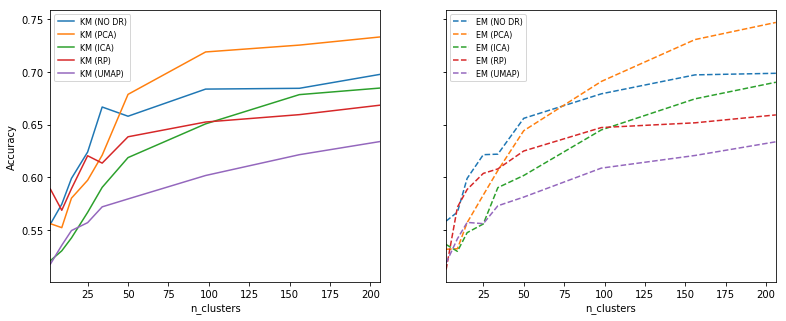

In [90]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))

for this_dr in df.loc[:, 'dr'].unique():
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'KM ({this_dr.upper()})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'EM ({this_dr.upper()})', ax=axs[1], ls='--', c=c)
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_ylabel("Accuracy")
fig.savefig(f'{casename}_majority_vote_accuracy.png')

In [ ]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))

mlp_no_reduction = pd.read_csv(f'synthetic_nn_all_features_results.csv')
axs[0].hlines(mlp_no_reduction.loc[:, 'mean_test_score'].max(), df.n_clusters.min(), df.n_clusters.max(), label='MLP (No Cluster or DR)', linestyle=':')
axs[1].hlines(mlp_no_reduction.loc[:, 'mean_test_score'].max(), df.n_clusters.min(), df.n_clusters.max(), label='MLP (No Cluster or DR)', linestyle=':')

for this_dr in df.loc[:, 'dr'].unique():
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'KM ({this_dr.upper()})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'EM ({this_dr.upper()})', ax=axs[1], ls='--', c=c)
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_ylabel("Accuracy")

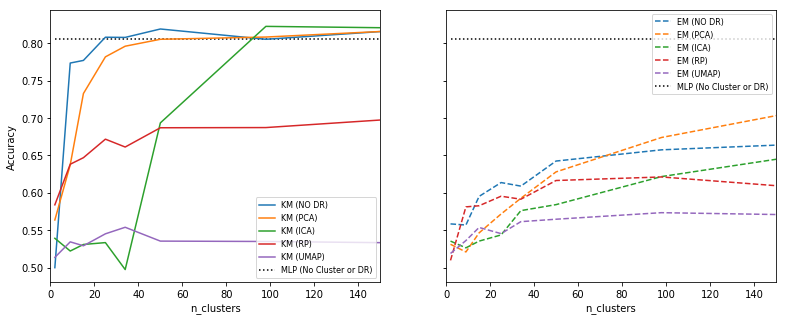

In [93]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))

mlp_no_reduction = pd.read_csv(f'synthetic_nn_all_features_results.csv')
axs[0].hlines(mlp_no_reduction.loc[:, 'mean_test_score'].max(), df.n_clusters.min(), df.n_clusters.max(), label='MLP (No Cluster or DR)', linestyle=':')
axs[1].hlines(mlp_no_reduction.loc[:, 'mean_test_score'].max(), df.n_clusters.min(), df.n_clusters.max(), label='MLP (No Cluster or DR)', linestyle=':')

for this_dr in df.loc[:, 'dr'].unique():
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'KM ({this_dr.upper()})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'EM ({this_dr.upper()})', ax=axs[1], ls='--', c=c)
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_xlim((0, 150))
axs[1].set_xlim((0, 150))
axs[0].set_ylabel("Accuracy")
fig.savefig(f'{casename}_clustered_mlp.png')

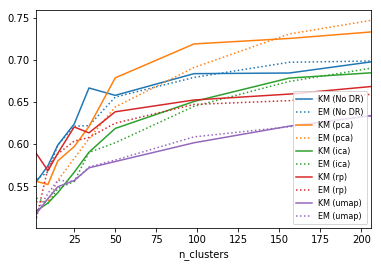

In [83]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='accuracy', label='KM (no DR)', lw=3, ls='-', ax=ax)
# # ax2 = ax.twinx()
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df.loc[:, 'dr'].unique():
    
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
# ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

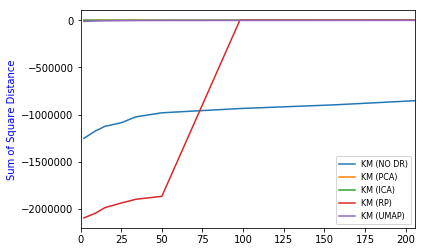

In [89]:
fig, ax = plt.subplots()
ax.set_ylabel("Sum of Square Distance", color='b')

for this_dr in df.loc[:, 'dr'].unique():
#     if "No DR" in this_dr:
#         continue
    this_x = df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "n_clusters"]
    this_y = -df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "score"]
#     this_y = this_y / this_y.max()
    ax.plot(this_x, this_y, label=f'KM ({this_dr.upper()})', ls='-')
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

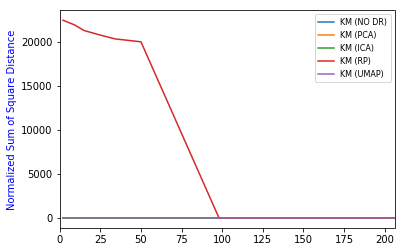

In [87]:
fig, ax = plt.subplots()
ax.set_ylabel("Normalized Sum of Square Distance", color='b')

for this_dr in df.loc[:, 'dr'].unique():
#     if "No DR" in this_dr:
#         continue
    this_x = df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "n_clusters"]
    this_y = -df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "score"]
    this_y = this_y / this_y.max()
    ax.plot(this_x, this_y, label=f'KM ({this_dr.upper()})', ls='-')
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)
fig.savefig(f'{casename}_km_sse.png')

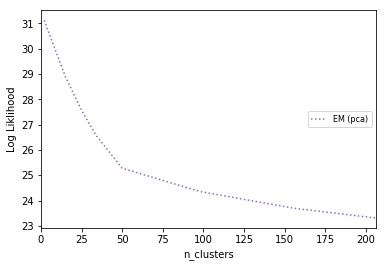

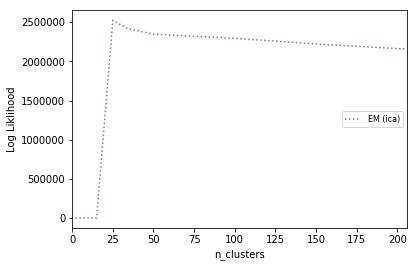

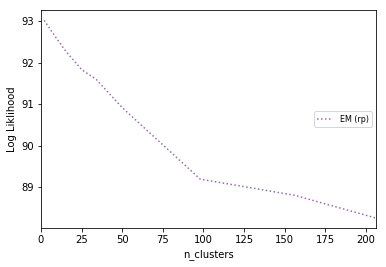

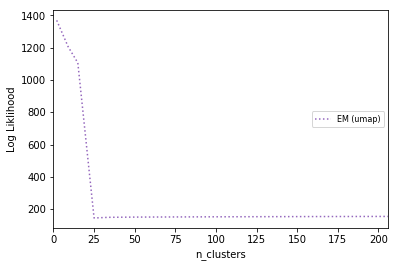

In [88]:
for this_dr in df.loc[:, 'dr'].unique():
    if "No DR" in this_dr:
        continue
    fig, ax = plt.subplots()

    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)

    ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
    ax.set_ylabel('Log Liklihood')
#     ax.semilogy()
    ax.legend(fontsize=8, loc="right")
    plt.show()


# Use this cluster vis?  If so, may want to change n-clusters

In [ ]:
this_scaler = StandardScaler()
X_scaled_for_vis = this_scaler.fit_transform(X)
km = KMeans(n_clusters=6, random_state=random_state)
km.fit(X_scaled_for_vis)

In [ ]:
fig, ax = plt.subplots()

# make a color map of fixed colors
cmap = colors.ListedColormap(['black', 'blue', 'red', 'green', 'purple', 'yellow'])
bounds = np.linspace(y.min() - 0.5, y.max() + 0.5, len(np.unique(y)) + 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

# sc = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, s=1, cmap=cmap, norm=norm)
sc = ax.scatter(X[:, 0], X[:, 1], c=km.predict(X_scaled_for_vis), s=1, cmap=cmap, norm=norm)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.get_figure().colorbar(sc, cax=cax, ticks=[0, 1, 2, 3, 4, 5])

fig.savefig('synthetic_vis_pca.png')

# Old code

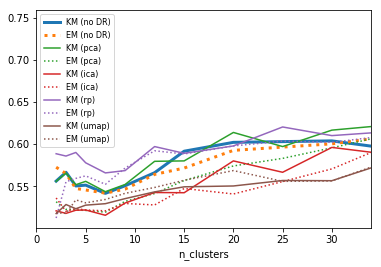

In [35]:
fig, ax = plt.subplots()
df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='accuracy_jontay', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy_jontay', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df_withdr.loc[:, 'dr'].unique():
    
    df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'km') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy_jontay', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'gmm') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy_jontay', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
ax.set_xlim((0, df_withdr.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

No handles with labels found to put in legend.


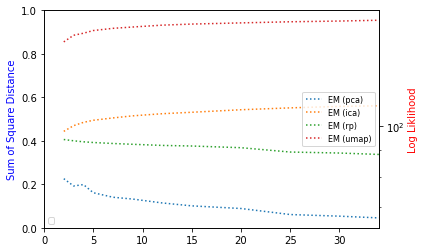

In [295]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='score', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
ax.set_ylabel("Sum of Square Distance", color='b')
ax2 = ax.twinx()
ax2.set_ylabel('Log Liklihood', color='r')
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='score', label='EM (no DR)', lw=3, ls=':', ax=ax2, c=c)

for this_dr in df_withdr.loc[:, 'dr'].unique():
    
#     df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'km') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = None#ax.get_lines()[-1].get_color()
    df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'gmm') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax2, ls=':', c=c)
ax.set_xlim((0, df_withdr.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8, loc="lower left")

ax2.semilogy()
ax2.legend(fontsize=8, loc="right")

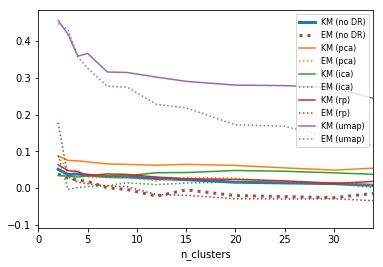

In [304]:
fig, ax = plt.subplots()
df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='silhouette', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='silhouette', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df_withdr.loc[:, 'dr'].unique():
    
    df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'km') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='silhouette', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'gmm') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='silhouette', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
ax.set_xlim((0, df_withdr.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

In [291]:
df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'gmm']

,accuracy,accuracy_jontay,accuracy_jontay_test,accuracy_test,clusterer,dr,n_clusters,score,silhouette,y_pred,y_test_pred
12,0.53175,0.53175,0.539,0.539,gmm,pca,2,-79.311605,0.086566,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
13,0.35950,0.52275,0.526,0.359,gmm,pca,3,-76.807638,0.047461,"[2, 0, 0, 0, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, ...","[0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, ..."
14,0.21025,0.52200,0.529,0.239,gmm,pca,4,-77.274242,0.048863,"[2, 0, 1, 1, 2, 1, 3, 3, 3, 0, 3, 2, 3, 2, 2, ...","[1, 1, 2, 3, 0, 2, 2, 0, 3, 1, 3, 2, 2, 1, 3, ..."
15,0.22175,0.52150,0.527,0.238,gmm,pca,5,-74.551638,0.029148,"[0, 4, 1, 1, 0, 1, 3, 2, 3, 0, 3, 0, 3, 0, 0, ...","[4, 1, 0, 4, 4, 2, 2, 0, 3, 3, 3, 0, 0, 1, 3, ..."
16,0.08625,0.51950,0.540,0.092,gmm,pca,7,-73.084222,0.029352,"[6, 0, 5, 4, 6, 1, 3, 4, 3, 0, 3, 6, 4, 6, 2, ...","[1, 5, 6, 4, 0, 2, 2, 0, 3, 3, 3, 6, 6, 4, 3, ..."
17,0.06875,0.53225,0.555,0.078,gmm,pca,9,-72.500190,0.028467,"[3, 0, 1, 5, 3, 6, 7, 2, 7, 0, 7, 3, 4, 3, 6, ...","[6, 5, 3, 4, 0, 2, 2, 0, 7, 4, 7, 3, 3, 5, 7, ..."
18,0.06850,0.54150,0.546,0.089,gmm,pca,12,-71.268611,0.019842,"[3, 0, 4, 8, 9, 1, 11, 2, 11, 0, 11, 9, 7, 9, ...","[6, 5, 9, 1, 0, 2, 2, 0, 11, 4, 7, 9, 9, 8, 11..."
19,0.04800,0.55700,0.547,0.060,gmm,pca,15,-70.360277,0.029240,"[3, 0, 4, 8, 2, 5, 7, 8, 7, 0, 7, 9, 10, 9, 3,...","[5, 14, 9, 10, 0, 2, 12, 0, 7, 4, 7, 3, 9, 8, ..."
20,0.04725,0.57425,0.587,0.058,gmm,pca,20,-69.544417,0.027214,"[3, 0, 4, 18, 9, 5, 7, 2, 7, 0, 7, 9, 19, 9, 6...","[14, 8, 9, 16, 0, 2, 8, 0, 7, 4, 7, 3, 9, 18, ..."
21,0.03975,0.58325,0.579,0.052,gmm,pca,25,-67.719111,0.016785,"[2, 10, 17, 8, 7, 9, 3, 5, 3, 10, 3, 14, 20, 5...","[0, 1, 2, 12, 10, 7, 1, 10, 3, 20, 3, 2, 14, 5..."


In [ ]:
fig, ax = plt.subplots()
df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='score', c='b', label='K-Means (distance)', ax=ax)
ax.set_ylabel("Sum of Square Distance", color='b')
ax.legend(loc='lower left')
ax2 = ax.twinx()
ax2.semilogy()
df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='score', c='r', label='Expectation Maximization (log liklihood)', ax=ax2)
ax2.set_ylabel('Log Liklihood', color='r')
ax2.set_yticks([100, 1000])
ax2.legend(loc=(.25, .85))

In [ ]:
fig, ax = plt.subplots()
df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='score', label='K-Means', ax=ax)
# # ax2 = ax.twinx()
# df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy_jontay', label='Expectation Maximization', ax=ax)


In [296]:
n_components = 206
drs = {
    'pca': PCA(n_components=n_components, random_state=random_state),
    'ica': FastICA(n_components=n_components, random_state=random_state, max_iter=max_iter),
    'rp': SparseRandomProjection(n_components=n_components, random_state=random_state),
    'umap': umap.UMAP(n_components=n_components, random_state=random_state),
}

results_2 = []

clusterers = ['km', 'gmm']

n_clusterss = [2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 30, 34, 50, 75, 100, 150, 200]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_test = scaler.transform(X_test)

for dr_name, dr in drs.items():
    print(f"Running for dr: {dr}")
    X_reduced = dr.fit_transform(X_scaled)
    X_reduced_test = dr.transform(X_scaled_test)
    for name in clusterers:
        print(f"Running for model: {name}")
        for n_clusters in n_clusterss:
            results_2.append({'dr': dr_name})
            results_2[-1]['clusterer'] = name
            print(f"\tn_clusters = {n_clusters}")
            results_2.append({'n_clusters': n_clusters})

            if name == 'km':
                clusterer = KMeans(n_clusters, random_state=random_state)
            elif name == 'gmm':
                clusterer = GaussianMixture(n_clusters, random_state=random_state)
            else:
                raise Exception(".")

            clusterer.fit(X_reduced)


    #         if n_clusters == 2:

            y_pred = clusterer.predict(X_reduced)
            results_2[-1]['y_pred'] = y_pred
            scores = [
                accuracy_score(y, y_pred), 
                accuracy_score(y, (y_pred - 1) * -1)
            ]

            results_2[-1]['accuracy'] = max(scores)
            results_2[-1]['accuracy_jontay'] = cluster_acc(y, y_pred)
            y_test_pred = clusterer.predict(X_reduced_test)
            results_2[-1]['y_test_pred'] = y_test_pred
            scores_test = [
                accuracy_score(y_test, y_test_pred), 
                accuracy_score(y_test, (y_test_pred - 1) * -1)
            ]

            results_2[-1]['accuracy_test'] = max(scores_test)
            results_2[-1]['accuracy_jontay_test'] = cluster_acc(y_test, y_test_pred)

            results_2[-1]['score'] = clusterer.score(X_reduced)
            results_2[-1]['silhouette'] = silhouette_score(X_reduced_test, results_2[-1]['y_test_pred'])

            print(f"Clustering as a classifier gives accuracy of: train={results_2[-1]['accuracy']:.3f} (jontay={results_2[-1]['accuracy_jontay']:.3f}), test={results_2[-1]['accuracy_test']:.3f} (jontay={results_2[-1]['accuracy_jontay_test']:.3f}, ")

Running for dr: PCA(copy=True, iterated_power='auto', n_components=206, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)
Running for model: km
	n_clusters = 2
Clustering as a classifier gives accuracy of: train=0.557 (jontay=0.557), test=0.580 (jontay=0.580, 
	n_clusters = 3
Clustering as a classifier gives accuracy of: train=0.362 (jontay=0.564), test=0.380 (jontay=0.572, 
	n_clusters = 4
Clustering as a classifier gives accuracy of: train=0.238 (jontay=0.552), test=0.240 (jontay=0.574, 
	n_clusters = 5
Clustering as a classifier gives accuracy of: train=0.236 (jontay=0.551), test=0.226 (jontay=0.565, 
	n_clusters = 7
Clustering as a classifier gives accuracy of: train=0.187 (jontay=0.540), test=0.192 (jontay=0.566, 
	n_clusters = 9
Clustering as a classifier gives accuracy of: train=0.105 (jontay=0.548), test=0.100 (jontay=0.568, 
	n_clusters = 12
Clustering as a classifier gives accuracy of: train=0.120 (jontay=0.577), test=0.113 (jontay=0.579, 
	n_clusters = 15
Clusterin

Clustering as a classifier gives accuracy of: train=0.001 (jontay=0.613), test=0.000 (jontay=0.520, 
Running for dr: SparseRandomProjection(dense_output=False, density='auto', eps=0.1,
            n_components=206, random_state=1)
Running for model: km
	n_clusters = 2
Clustering as a classifier gives accuracy of: train=0.581 (jontay=0.581), test=0.600 (jontay=0.600, 
	n_clusters = 3
Clustering as a classifier gives accuracy of: train=0.321 (jontay=0.558), test=0.331 (jontay=0.590, 
	n_clusters = 4
Clustering as a classifier gives accuracy of: train=0.328 (jontay=0.563), test=0.338 (jontay=0.587, 
	n_clusters = 5
Clustering as a classifier gives accuracy of: train=0.215 (jontay=0.561), test=0.237 (jontay=0.577, 
	n_clusters = 7
Clustering as a classifier gives accuracy of: train=0.130 (jontay=0.550), test=0.131 (jontay=0.562, 
	n_clusters = 9
Clustering as a classifier gives accuracy of: train=0.101 (jontay=0.558), test=0.087 (jontay=0.574, 
	n_clusters = 12
Clustering as a classifier g

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Clustering as a classifier gives accuracy of: train=0.553 (jontay=0.553), test=0.554 (jontay=0.554, 
	n_clusters = 3
Clustering as a classifier gives accuracy of: train=0.401 (jontay=0.545), test=0.411 (jontay=0.556, 
	n_clusters = 4
Clustering as a classifier gives accuracy of: train=0.304 (jontay=0.548), test=0.304 (jontay=0.556, 
	n_clusters = 5
Clustering as a classifier gives accuracy of: train=0.196 (jontay=0.551), test=0.167 (jontay=0.546, 
	n_clusters = 7
Clustering as a classifier gives accuracy of: train=0.175 (jontay=0.539), test=0.180 (jontay=0.543, 
	n_clusters = 9
Clustering as a classifier gives accuracy of: train=0.128 (jontay=0.549), test=0.141 (jontay=0.532, 
	n_clusters = 12
Clustering as a classifier gives accuracy of: train=0.103 (jontay=0.567), test=0.079 (jontay=0.554, 
	n_clusters = 15
Clustering as a classifier gives accuracy of: train=0.050 (jontay=0.588), test=0.003 (jontay=0.572, 
	n_clusters = 20
Clustering as a classifier gives accuracy of: train=0.038 (jo

In [297]:
joblib.dump(results_2, f"{casename}_withdr_{n_components}_results.pkl")

['quickdraw_clustering_withdr_206_results.pkl']

In [298]:
df_withdr_long = pd.DataFrame(results)
# df_withdr = df_withdr.loc[~df_withdr.loc[:, 'score'].isna(), :]
# df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'km', 'score'] = df_withdr.loc[df_withdr.loc[:, 'clusterer'] == 'km', 'score'] * -1 
df_withdr_long.loc[:, 'score'] = df_withdr_long.loc[:, 'score'].abs()
df_withdr_long.to_csv(f"{casename}_withdr_{n_components}_results.csv")

In [299]:
df_withdr_long

,accuracy,accuracy_jontay,accuracy_jontay_test,accuracy_test,clusterer,dr,n_clusters,score,silhouette,y_pred,y_test_pred
0,0.55600,0.55600,0.579,0.579,km,pca,2,1.252475e+06,0.087527,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ..."
1,0.36400,0.56575,0.570,0.380,km,pca,3,1.175496e+06,0.075583,"[2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, ...","[2, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, ..."
2,0.26450,0.55200,0.569,0.288,km,pca,4,1.124930e+06,0.074227,"[2, 1, 0, 0, 1, 0, 3, 2, 3, 1, 3, 1, 0, 2, 2, ...","[0, 0, 1, 3, 1, 2, 2, 1, 3, 0, 3, 1, 1, 2, 3, ..."
3,0.19800,0.55600,0.571,0.186,km,pca,5,1.086855e+06,0.071441,"[0, 4, 3, 3, 4, 3, 2, 1, 2, 4, 2, 4, 2, 0, 0, ...","[3, 3, 4, 2, 4, 1, 0, 4, 2, 3, 2, 0, 4, 1, 4, ..."
4,0.15100,0.54375,0.562,0.151,km,pca,7,1.024645e+06,0.066062,"[2, 6, 4, 0, 2, 5, 1, 0, 1, 6, 1, 6, 4, 2, 2, ...","[3, 5, 6, 1, 6, 0, 5, 6, 1, 4, 4, 2, 6, 0, 1, ..."
5,0.14125,0.55225,0.557,0.153,km,pca,9,9.813338e+05,0.064668,"[3, 1, 0, 6, 8, 6, 5, 8, 5, 1, 5, 3, 0, 3, 3, ...","[7, 6, 3, 5, 1, 8, 4, 1, 5, 0, 0, 3, 3, 8, 5, ..."
6,0.13525,0.57975,0.580,0.115,km,pca,12,9.361311e+05,0.062462,"[0, 3, 2, 4, 10, 7, 1, 10, 1, 3, 1, 8, 2, 0, 0...","[5, 11, 8, 1, 3, 10, 11, 3, 1, 2, 2, 0, 8, 11,..."
7,0.09675,0.58025,0.584,0.091,km,pca,15,8.971964e+05,0.064952,"[7, 3, 14, 9, 0, 9, 1, 0, 1, 10, 1, 3, 5, 7, 7...","[4, 9, 3, 1, 10, 2, 6, 10, 1, 14, 12, 7, 3, 8,..."
8,0.07950,0.61400,0.614,0.080,km,pca,20,8.528066e+05,0.061912,"[10, 1, 13, 4, 2, 4, 8, 17, 8, 5, 16, 1, 9, 2,...","[11, 12, 1, 7, 5, 14, 19, 5, 8, 3, 3, 2, 1, 17..."
9,0.04950,0.59725,0.608,0.067,km,pca,25,8.195985e+05,0.055251,"[1, 12, 16, 24, 10, 5, 23, 10, 23, 3, 9, 15, 4...","[18, 5, 15, 21, 3, 21, 8, 3, 9, 22, 22, 15, 12..."


In [300]:
df_withdr_long.loc[:, 'dr'].unique()

array(['pca', 'ica', 'rp', 'umap'], dtype=object)

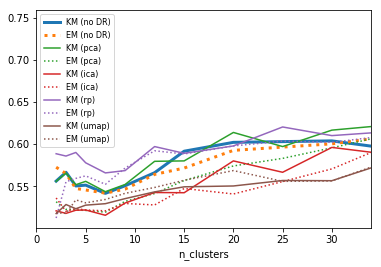

In [301]:
fig, ax = plt.subplots()
df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='accuracy_jontay', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy_jontay', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df_withdr.loc[:, 'dr'].unique():
    
    df_withdr_long.loc[(df_withdr.loc[:, 'clusterer'] == 'km') & (df_withdr_long.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy_jontay', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df_withdr_long.loc[(df_withdr.loc[:, 'clusterer'] == 'gmm') & (df_withdr_long.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy_jontay', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
ax.set_xlim((0, df_withdr.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

No handles with labels found to put in legend.


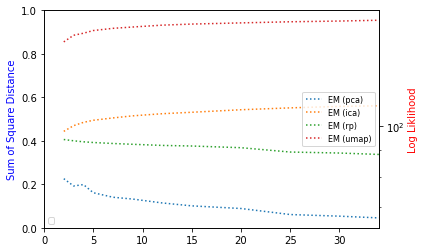

In [302]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='score', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
ax.set_ylabel("Sum of Square Distance", color='b')
ax2 = ax.twinx()
ax2.set_ylabel('Log Liklihood', color='r')
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='score', label='EM (no DR)', lw=3, ls=':', ax=ax2, c=c)

for this_dr in df_withdr_long.loc[:, 'dr'].unique():
    
#     df_withdr.loc[(df_withdr.loc[:, 'clusterer'] == 'km') & (df_withdr.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = None#ax.get_lines()[-1].get_color()
    df_withdr_long.loc[(df_withdr_long.loc[:, 'clusterer'] == 'gmm') & (df_withdr_long.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax2, ls=':', c=c)
ax.set_xlim((0, df_withdr_long.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8, loc="lower left")

ax2.semilogy()
ax2.legend(fontsize=8, loc="right")

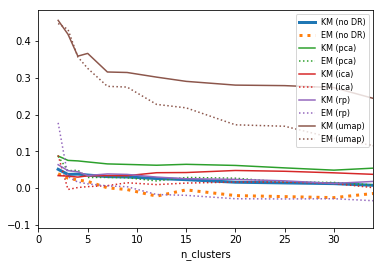

In [303]:
fig, ax = plt.subplots()
df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='silhouette', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='silhouette', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df_withdr.loc[:, 'dr'].unique():
    
    df_withdr_long.loc[(df_withdr.loc[:, 'clusterer'] == 'km') & (df_withdr_long.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='silhouette', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df_withdr_long.loc[(df_withdr.loc[:, 'clusterer'] == 'gmm') & (df_withdr_long.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='silhouette', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
ax.set_xlim((0, df_withdr.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

# Evaluation with external metric (NN)

In [331]:
pca = PCA(10)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [332]:
data = pca.transform(X)
print(data.shape)

(4000, 10)


In [353]:
n_components = 98
drs = {
    'No DR': None,
    'PCA': PCA(n_components=n_components, random_state=random_state),
    'ICA': FastICA(n_components=n_components, random_state=random_state, max_iter=max_iter),
    'RP': SparseRandomProjection(n_components=n_components, random_state=random_state),
    'UMAP': umap.UMAP(n_components=n_components, random_state=random_state),
}

hidden_layer_sizes = [(2, ), (4, ), (6, )]

results = []

# clusterers = ['gmm']

# n_clusterss = [2]

clusterers = ['km', 'gmm']

n_clusterss = [2, 3, 5, 7, 10, 15, 20, 25, 34, 50, 75, 98]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_test = scaler.transform(X_test)

for dr_name, dr in drs.items():
    if dr is None:
        X_reduced = X.copy()
        X_reduced_test = X_test.copy()
    else:
        X_reduced = dr.fit_transform(X_scaled)
        X_reduced_test = dr.transform(X_scaled_test)

    for name in clusterers:
        for n_clusters in n_clusterss:
            print(f"{dr_name} {name} n_clust={n_clusters}", end='')

            results.append({})
            results[-1]['dr'] = dr_name
            results[-1]['clusterer'] = name
            results[-1]['n_clusters'] = n_clusters
#             results[-1]['dr_obj'] = dr
            
            # Prepare clusterer and predict labels
            if name == 'km':
                clusterer = KMeans(n_clusters, random_state=random_state)
            elif name == 'gmm':
                clusterer = gmm_wrapper(n_clusters, random_state=random_state)
            else:
                raise Exception(".")
            clusterer.fit(X_reduced)
            
            X_clustered = clusterer.transform(X_reduced)
            X_test_clustered = clusterer.transform(X_reduced_test)
            y_pred = clusterer.predict(X_reduced)
            y_test_pred = clusterer.predict(X_reduced_test)

            # Store clustering results
            results[-1]['y_pred'] = y_pred
            results[-1]['y_test_pred'] = y_test_pred
#             results[-1]['cluster_obj'] = clusterer
                        
            # Compute internal metrics
            results[-1]['accuracy'] = cluster_acc(y, y_pred)
            results[-1]['accuracy_test'] = cluster_acc(y_test, y_test_pred)
            results[-1]['score'] = clusterer.score(X_reduced)
            results[-1]['score_test'] = clusterer.score(X_reduced_test)
            results[-1]['silhouette'] = silhouette_score(X_reduced, results[-1]['y_pred'])
            results[-1]['silhouette_test'] = silhouette_score(X_reduced_test, results[-1]['y_test_pred'])
            results[-1]['mutual_info'] = mutual_info_score(y, results[-1]['y_pred'])
            results[-1]['mutual_info_test'] = mutual_info_score(y_test, results[-1]['y_test_pred'])
            results[-1]['normalized_mutual_info'] = normalized_mutual_info_score(y, results[-1]['y_pred'], average_method='arithmetic')
            results[-1]['normalized_mutual_info_test'] = normalized_mutual_info_score(y_test, results[-1]['y_test_pred'], average_method='arithmetic')
            results[-1]['adjusted_rand'] = adjusted_rand_score(y, results[-1]['y_pred'])
            results[-1]['adjusted_rand_test'] = adjusted_rand_score(y_test, results[-1]['y_test_pred'])
            
            print(f" (test) acc={results[-1]['accuracy_test']:.2f}, sil={results[-1]['silhouette_test']:.3f}, nmi={results[-1]['normalized_mutual_info_test']:.3f}", end='')

            # Compute MLP
            param_grid = {'hidden_layer_sizes': hidden_layer_sizes}
            gs = GridSearchCV(MLPClassifier(max_iter=max_iter, random_state=random_state),
                             param_grid=param_grid, verbose=0, cv=3, return_train_score=True,
                             n_jobs=n_jobs)
            gs.fit(X_clustered, y)
            results[-1]['gs_object'] = gs
            results[-1]['mlp_cv_score'] = gs.best_score_
            results[-1]['mlp_test_score'] = gs.score(X_test_clustered, y_test)
                  
            print(f", mlp_cv={results[-1]['mlp_cv_score']}")
        # Save results along the way
        joblib.dump(results, f"{casename}_gs_results_intermediate.pkl")
                  

No DR km n_clust=2 (test) acc=0.58, sil=0.050, nmi=0.018, mlp_cv=0.5
No DR km n_clust=3 (test) acc=0.58, sil=0.050, nmi=0.018, mlp_cv=0.61825
No DR km n_clust=5 (test) acc=0.57, sil=0.039, nmi=0.013, mlp_cv=0.599
No DR km n_clust=7 (test) acc=0.56, sil=0.036, nmi=0.007, mlp_cv=0.65925
No DR km n_clust=10 (test) acc=0.61, sil=0.029, nmi=0.023, mlp_cv=0.79875
No DR km n_clust=15 (test) acc=0.60, sil=0.024, nmi=0.021, mlp_cv=0.777
No DR km n_clust=20 (test) acc=0.64, sil=0.016, nmi=0.034, mlp_cv=0.81925
No DR km n_clust=25 (test) acc=0.63, sil=0.017, nmi=0.027, mlp_cv=0.808
No DR km n_clust=34 (test) acc=0.67, sil=0.010, nmi=0.044, mlp_cv=0.80775
No DR km n_clust=50 (test) acc=0.69, sil=0.006, nmi=0.048, mlp_cv=0.819
No DR km n_clust=75 (test) acc=0.69, sil=0.005, nmi=0.048, mlp_cv=0.81625
No DR km n_clust=98 (test) acc=0.70, sil=-0.006, nmi=0.054, mlp_cv=0.80525
No DR gmm n_clust=2 (test) acc=0.58, sil=0.039, nmi=0.017, mlp_cv=0.5585
No DR gmm n_clust=3 (test) acc=0.56, sil=0.028, nmi=0.

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


 (test) acc=0.53, sil=0.026, nmi=0.002, mlp_cv=0.51925
PCA gmm n_clust=5 (test) acc=0.54, sil=0.033, nmi=0.003, mlp_cv=0.52325
PCA gmm n_clust=7 (test) acc=0.54, sil=0.016, nmi=0.004, mlp_cv=0.5105
PCA gmm n_clust=10 (test) acc=0.55, sil=0.014, nmi=0.006, mlp_cv=0.5119999999999999
PCA gmm n_clust=15 (test) acc=0.56, sil=0.012, nmi=0.006, mlp_cv=0.57675
PCA gmm n_clust=20 (test) acc=0.59, sil=0.006, nmi=0.012, mlp_cv=0.5635
PCA gmm n_clust=25 (test) acc=0.59, sil=-0.009, nmi=0.013, mlp_cv=0.56675
PCA gmm n_clust=34 (test) acc=0.60, sil=-0.032, nmi=0.018, mlp_cv=0.579
PCA gmm n_clust=50 (test) acc=0.58, sil=-0.068, nmi=0.014, mlp_cv=0.628
PCA gmm n_clust=75 (test) acc=0.50, sil=-0.006, nmi=0.002, mlp_cv=0.65175
PCA gmm n_clust=98 (test) acc=0.58, sil=-0.079, nmi=0.021, mlp_cv=0.6725
ICA km n_clust=2 (test) acc=0.55, sil=0.024, nmi=0.007, mlp_cv=0.5
ICA km n_clust=3 (test) acc=0.54, sil=0.002, nmi=0.004, mlp_cv=0.55375
ICA km n_clust=5 (test) acc=0.53, sil=0.009, nmi=0.002, mlp_cv=0.56525

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\mixture\base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


 (test) acc=0.55, sil=-0.019, nmi=0.008, mlp_cv=0.51525
ICA gmm n_clust=10 (test) acc=0.55, sil=-0.012, nmi=0.006, mlp_cv=0.525
ICA gmm n_clust=15 (test) acc=0.55, sil=-0.010, nmi=0.004, mlp_cv=0.527
ICA gmm n_clust=20 (test) acc=0.55, sil=-0.014, nmi=0.004, mlp_cv=0.5295
ICA gmm n_clust=25 (test) acc=0.55, sil=-0.030, nmi=0.008, mlp_cv=0.549
ICA gmm n_clust=34 (test) acc=0.59, sil=-0.037, nmi=0.015, mlp_cv=0.5615
ICA gmm n_clust=50 (test) acc=0.59, sil=-0.039, nmi=0.015, mlp_cv=0.56925
ICA gmm n_clust=75 (test) acc=0.56, sil=-0.075, nmi=0.012, mlp_cv=0.56975
ICA gmm n_clust=98 (test) acc=0.56, sil=-0.086, nmi=0.018, mlp_cv=0.57325
RP km n_clust=2 (test) acc=0.58, sil=0.046, nmi=0.021, mlp_cv=0.5
RP km n_clust=3 (test) acc=0.57, sil=0.040, nmi=0.013, mlp_cv=0.58125
RP km n_clust=5 (test) acc=0.56, sil=0.030, nmi=0.012, mlp_cv=0.5885
RP km n_clust=7 (test) acc=0.56, sil=0.020, nmi=0.010, mlp_cv=0.6215
RP km n_clust=10 (test) acc=0.59, sil=0.022, nmi=0.014, mlp_cv=0.57175
RP km n_clust=1

In [348]:
for result in results:
    print(f'{result["dr"]} {result["clusterer"]} {result["mlp_test_score"]}, {result["mlp_pipe_test_score"]}')

No DR km 0.5, 0.681
No DR gmm 0.58, 0.577
PCA km 0.5, 0.5
PCA gmm 0.522, 0.522
ICA km 0.5, 0.5
ICA gmm 0.533, 0.533
RP km 0.5, 0.499
RP gmm 0.495, 0.495


In [354]:
joblib.dump(results, f"{casename}_gs_results.pkl")

['quickdraw_clustering_gs_results.pkl']

In [11]:
# df = pd.read_csv(f'{casename}_gs_results.csv')

In [355]:
df = pd.DataFrame(results)
df.to_csv(f"{casename}_gs_results.csv")
# df.loc[df.loc[:, 'clusterer'] == 'km', 'score'] = df.loc[df.loc[:, 'clusterer'] == 'km', 'score'] * -1 

In [12]:
df

,Unnamed: 0,accuracy,accuracy_test,adjusted_rand,adjusted_rand_test,clusterer,dr,gs_object,mlp_cv_score,mlp_test_score,...,mutual_info_test,n_clusters,normalized_mutual_info,normalized_mutual_info_test,score,score_test,silhouette,silhouette_test,y_pred,y_test_pred
0,0,0.55575,0.579,0.012185,0.023987,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.50000,0.500,...,1.253861e-02,2,0.008987,1.809150e-02,-3.033639e+05,-7.568182e+04,0.047830,0.050394,[0 1 0 ... 0 1 1],[0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0...
1,1,0.54825,0.584,0.006751,0.020017,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.61825,0.674,...,1.582095e-02,3,0.005625,1.775849e-02,-2.930342e+05,-7.317936e+04,0.048087,0.050173,[1 1 2 ... 0 1 2],[0 0 1 2 1 1 0 1 2 2 2 1 1 0 1 2 2 2 0 1 0 2 0...
2,2,0.55725,0.569,0.006928,0.011444,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.59900,0.684,...,1.470390e-02,5,0.007573,1.288351e-02,-2.817422e+05,-7.061627e+04,0.039706,0.039110,[3 2 4 ... 4 3 0],[1 1 2 0 2 3 1 2 0 4 4 3 2 1 0 0 0 0 1 3 1 4 1...
3,3,0.54400,0.558,0.004080,0.003942,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.65925,0.661,...,9.705645e-03,7,0.005677,7.371789e-03,-2.748864e+05,-6.886806e+04,0.035317,0.036098,[6 1 5 ... 5 6 0],[4 3 6 0 1 2 4 1 0 5 5 6 6 2 0 0 0 0 5 6 2 5 3...
4,4,0.60375,0.607,0.012053,0.010898,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.79875,0.791,...,3.367655e-02,10,0.024094,2.255611e-02,-2.684322e+05,-6.733835e+04,0.030297,0.029480,[9 2 5 ... 5 6 4],[1 1 9 2 3 6 8 3 4 5 0 9 2 7 4 0 4 0 7 9 7 5 1...
5,5,0.59900,0.600,0.008212,0.007458,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.77700,0.770,...,3.616793e-02,15,0.020822,2.136975e-02,-2.612280e+05,-6.600391e+04,0.027229,0.024008,[4 8 6 ... 6 5 2],[10 7 8 12 0 5 7 0 2 14 11 4 8 1 2 ...
6,6,0.62425,0.644,0.008723,0.009380,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.81925,0.790,...,6.165247e-02,20,0.026565,3.359236e-02,-2.567660e+05,-6.517739e+04,0.022009,0.016396,[16 12 1 ... 1 16 13],[ 9 19 10 0 6 18 14 6 13 15 3 7 10 18 13 ...
7,7,0.62400,0.628,0.006445,0.006073,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.80800,0.786,...,5.315706e-02,25,0.024838,2.731657e-02,-2.530763e+05,-6.447509e+04,0.021735,0.017467,[20 0 22 ... 11 14 12],[ 2 8 20 13 18 24 21 18 12 23 4 20 19 5 12 ...
8,8,0.66675,0.672,0.008869,0.008457,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.80775,0.813,...,9.270087e-02,34,0.040401,4.429611e-02,-2.479499e+05,-6.355756e+04,0.017753,0.010328,[10 27 30 ... 30 2 26],[28 12 2 31 26 24 4 15 3 23 21 9 16 0 14 ...
9,9,0.65800,0.689,0.005416,0.006086,km,No DR,"GridSearchCV(cv=3, error_score='raise-deprecat...",0.81900,0.805,...,1.098062e-01,50,0.035678,4.816496e-02,-2.417104e+05,-6.224312e+04,0.014333,0.006489,[10 28 40 ... 40 20 30],[12 14 29 9 30 25 36 2 24 15 26 31 33 47 42 ...


Text(0, 0.5, 'Accuracy')

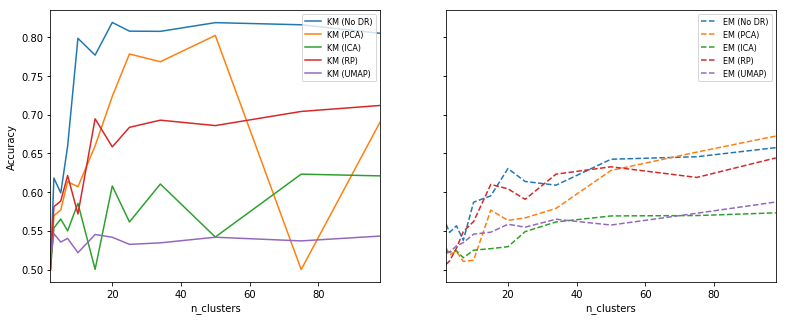

In [13]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='accuracy', label='KM (no DR)', lw=3, ls='-', ax=ax)
# # ax2 = ax.twinx()
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df.loc[:, 'dr'].unique():
    
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'KM ({this_dr})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'EM ({this_dr})', ax=axs[1], ls='--', c=c)
# ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_ylabel("Accuracy")

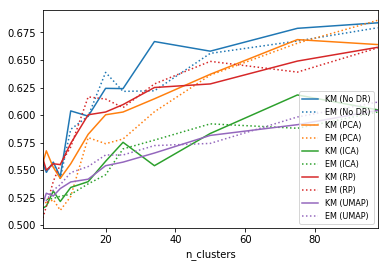

In [14]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='accuracy', label='KM (no DR)', lw=3, ls='-', ax=ax)
# # ax2 = ax.twinx()
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df.loc[:, 'dr'].unique():
    
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
# ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

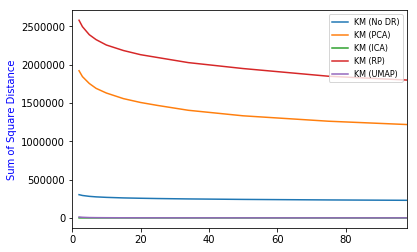

In [27]:
fig, ax = plt.subplots()
ax.set_ylabel("Sum of Square Distance", color='b')

for this_dr in df.loc[:, 'dr'].unique():
#     if "No DR" in this_dr:
#         continue
    this_x = df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "n_clusters"]
    this_y = -df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "score"]
#     this_y = this_y / this_y.max()
    ax.plot(this_x, this_y, label=f'KM ({this_dr})', ls='-')
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

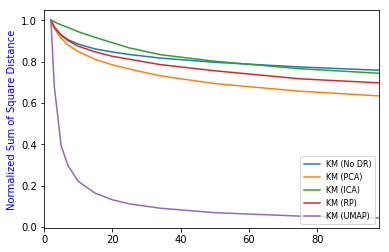

In [19]:
fig, ax = plt.subplots()
ax.set_ylabel("Normalized Sum of Square Distance", color='b')

for this_dr in df.loc[:, 'dr'].unique():
#     if "No DR" in this_dr:
#         continue
    this_x = df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "n_clusters"]
    this_y = -df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "score"]
    this_y = this_y / this_y.max()
    ax.plot(this_x, this_y, label=f'KM ({this_dr})', ls='-')
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

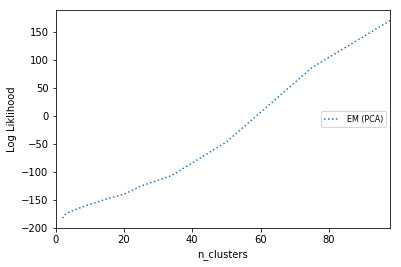

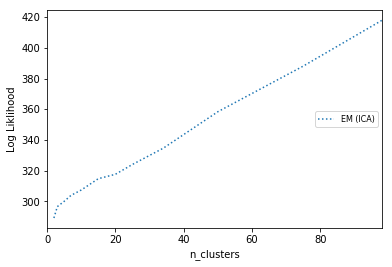

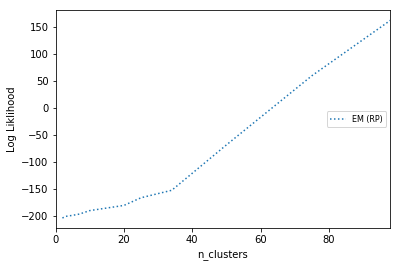

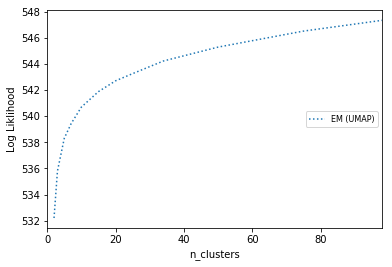

In [29]:
for this_dr in df.loc[:, 'dr'].unique():
    if "No DR" in this_dr:
        continue
    fig, ax = plt.subplots()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)

    ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
    ax.set_ylabel('Log Liklihood')
#     ax.semilogy()
    ax.legend(fontsize=8, loc="right")
    plt.show()
    


No handles with labels found to put in legend.


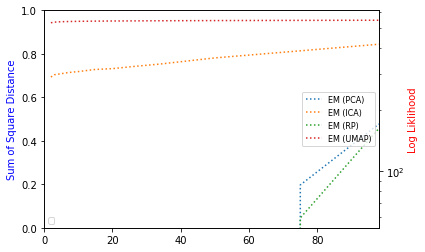

In [24]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='score', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
ax.set_ylabel("Sum of Square Distance", color='b')
ax2 = ax.twinx()
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='score', label='EM (no DR)', lw=3, ls=':', ax=ax2, c=c)

for this_dr in df.loc[:, 'dr'].unique():
    if "No DR" in this_dr:
        continue
    
#     df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = None#ax.get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax2, ls=':', c=c)
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8, loc="lower left")

ax2.set_ylabel('Log Liklihood', color='r')
ax2.semilogy()
ax2.legend(fontsize=8, loc="right")

In [25]:
this_scaler = StandardScaler()
X_scaled_for_vis = this_scaler.fit_transform(X)
km = KMeans(n_clusters=2, random_state=random_state)
X_embedded_2feat = km.fit_transform(X_scaled_for_vis)


(15, 40)

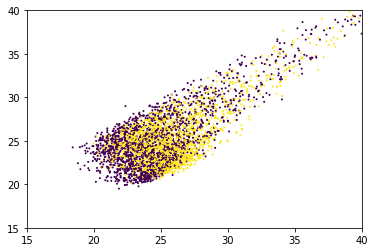

In [26]:
fig, ax = plt.subplots()
ax.scatter(X_embedded_2feat[:, 0], X_embedded_2feat[:, 1], s=1, c=y)
ax.set_xlim((15, 40))
ax.set_ylim((15, 40))